In [1]:
function kolmogorov_psd(C2n,L0,l0,k)
    Kolm_Phi = 0.033*C2n*k^(-11/3)
    return Kolm_Phi
end
function vonKarman_psd(C2n,L0,l0,k)
    k_m = 5.92/l0
    k_0 = 2*pi/L0
    vKarm_Phi = 0.033*C2n*exp(-k^2 / k_m^2)/((k^2 + k_0^2)^(11/6))
    return vKarm_Phi
end
function tatarski_psd(C2n,L0,l0,k)
    k_m = 5.92/l0
    ttrski_Phi = 0.033*k^(-11/3)*exp(-k^2/k_m^2)
    return ttrski_Phi
end
function mod_atm_psd(C2n,L0,l0,k)
    k_l = 3.3/l0
    k_0 = 2*pi/L0
    modatm_Phi =0.033*C2n*[1+1.802*(k/k_l)-0.254*(k/k_l)^(7/6)]*exp(-k^2/k_l^2)/((k^2+k_0^2)^(11/6))
    return modatm_Phi
end

mod_atm_psd (generic function with 1 method)

In [2]:
function meshgrid(x, y, nx, ny)
    X = repeat(x', nx, 1)
    Y = repeat(y,1, ny)
    return X, Y
end

meshgrid (generic function with 1 method)

In [3]:
function gen_gauss_beam(nx,ny,y_range,x_range,W_0,A_0,lambda)
 x = Array(LinRange(x_range[1], x_range[2], 500))
 y = Array(LinRange(y_range[1], y_range[2], 500))
 (X, Y) = meshgrid(x, y, nx, ny)
    k = 2*pi/lambda
    E = zeros(nx, ny)
    E = (A_0*exp.(-(X.^2 + Y.^2)/W_0^2))
    return E
end

gen_gauss_beam (generic function with 1 method)

In [4]:
function fresnel_prop(E,Lx,lambda,nx,z) #Convolution
    k = 2*pi/lambda
    dx = Lx/nx
     fx=-1/(2*dx):1/Lx:1/(2*dx)-1/Lx
    (FX , FY) = meshgrid(fx, fx, nx, ny)
    H = exp.((((FX.^2) + (FY.^2))*z*lambda*pi*-1*im))
    H = fftshift(H)
    U1=fft(fftshift(E))
    U2=H.*U1
    u2=ifftshift(ifft(U2))
   return u2          
end

fresnel_prop (generic function with 1 method)

In [5]:
function gen_phase_screen(turb_model::String,C2n, L0, l0,nx, ny, p_filter)
    k = 2*pi/l0
    if turb_model == "kolmogorov"
            PSD =  kolmogorov_psd(C2n,L0,l0,k)
    elseif turb_model == "vonKarman"
        PSD = vonKarman_psd(C2n,L0,l0,k)
    elseif turb_model == "tatarski"
        PSD = tatarski_psd(C2n,L0,l0,k)
    elseif turb_model == "modAtm"
        PSD = mod_atm_psd(C2n,L0,l0,k)
    end
    a_r = 1/sqrt(2)*(rand(nx, ny) + 1*im*rand(nx,ny));
    phase_field = a_r.*sqrt(PSD)/k
    phase_space = ifft(phase_field)
    std_ps = std(real(phase_space))
    mean_ps = mean(real(phase_space))
    cond1 = real(phase_space) .< mean_ps + p_filter*std_ps
    cond2 = real(phase_space) .> mean_ps - p_filter*std_ps
    result = cond1 .& cond2
    filt_ps = phase_space.*result
return filt_ps
end

gen_phase_screen (generic function with 1 method)

In [6]:
function R_x(d,dx,nx)
    d = d/dx
    mask = zeros(nx,nx)
    x_range = (1:nx)
    for y in x_range
        for x in x_range
            r_d = sqrt((x - (nx/2))^2 + (y - (nx/2))^2)
                if r_d <= (d/2)
                    mask[y, x] = 1
                end
        end
    end    
    return mask
end

R_x (generic function with 1 method)

Animation directory: ./test/
0


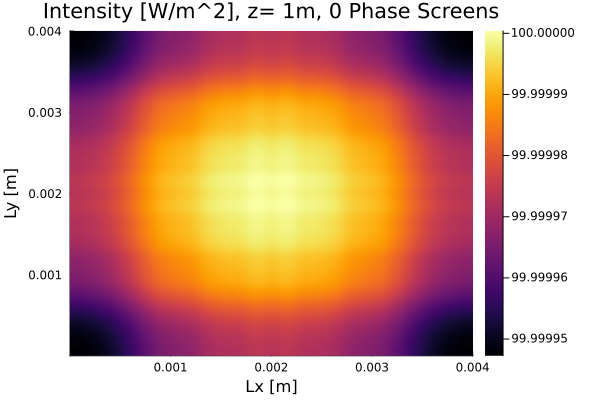

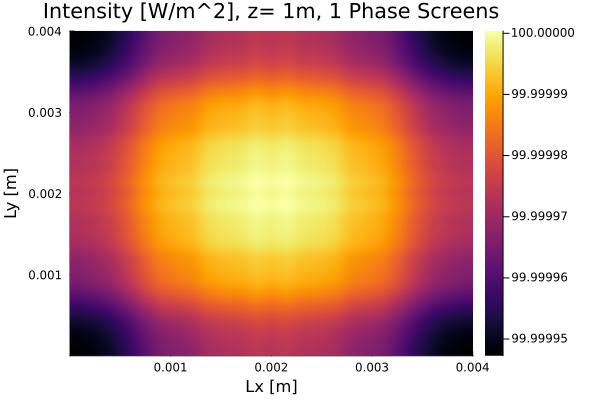

1


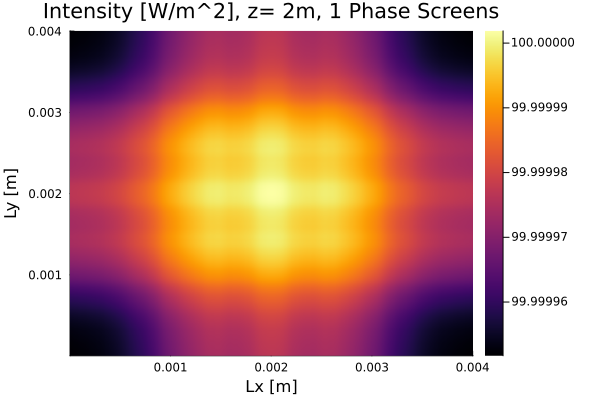

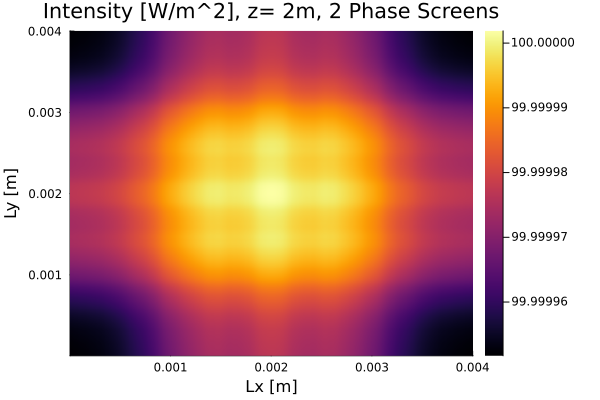

2


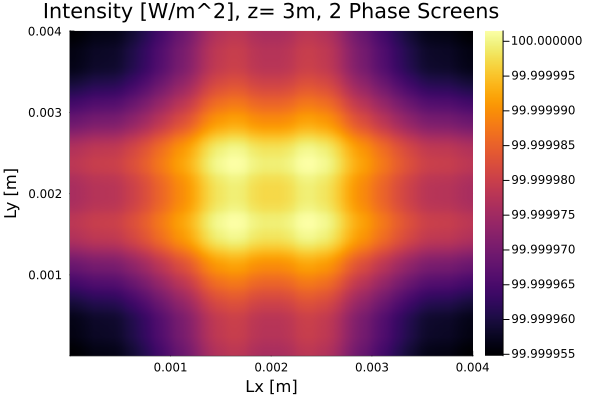

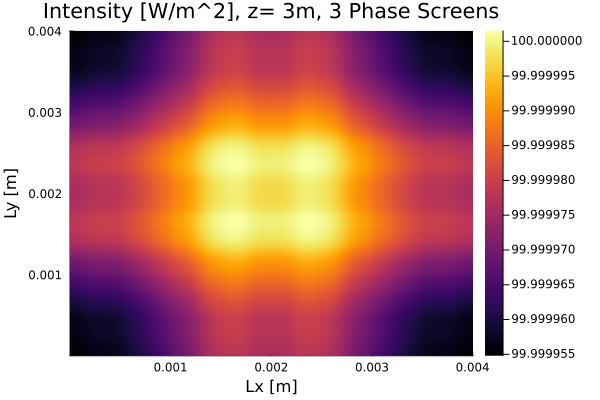

3


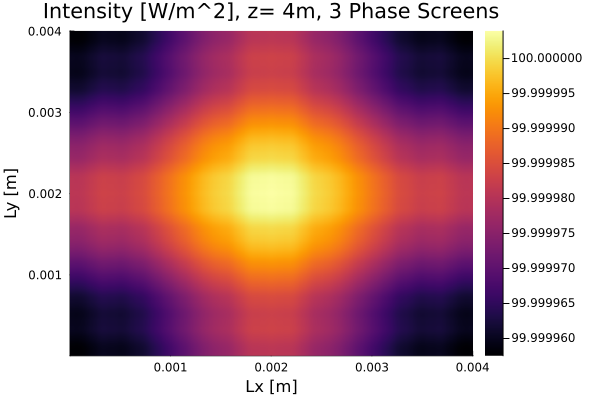

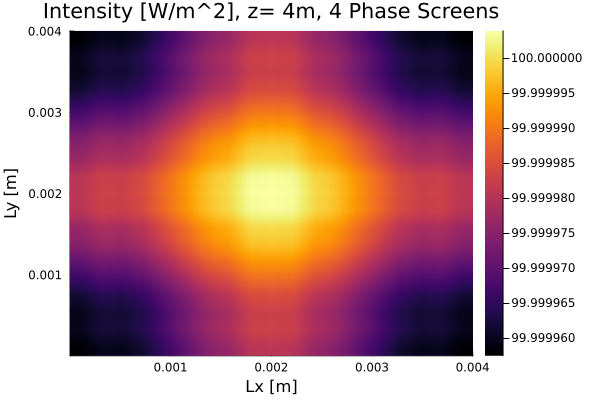

4


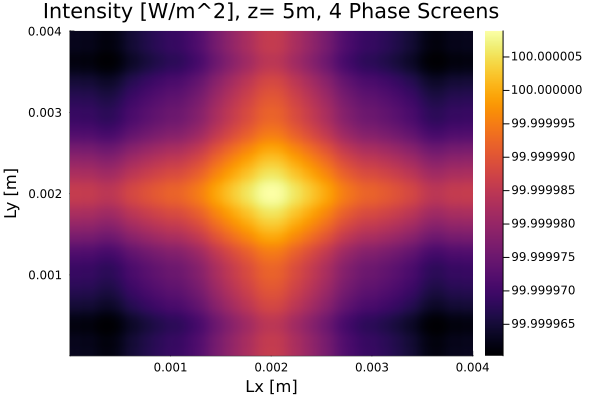

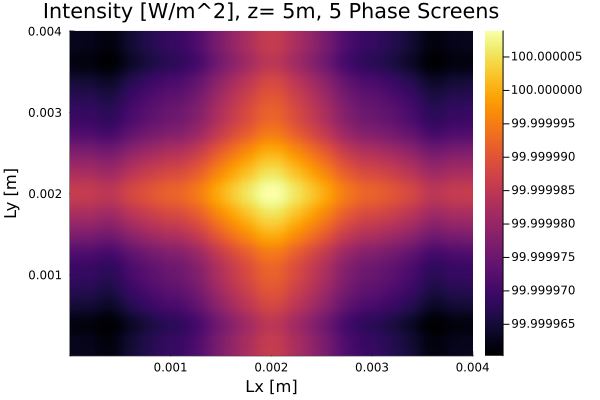

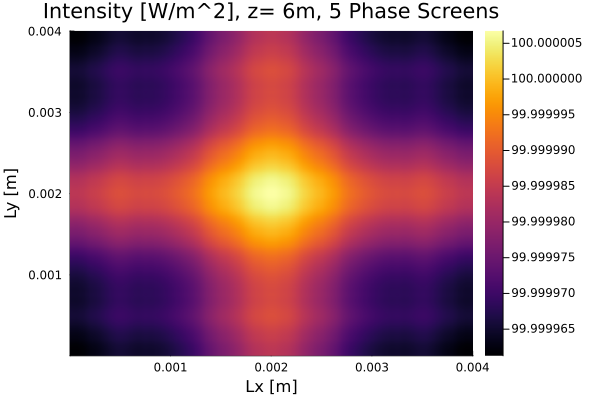

Intensity at Receiver: 15.41799324335693 W
Intensity Reduced by 3.8544991364280268%


In [8]:
using Plots
using DataFrames
using FFTW
using Statistics
nx = 500
ny = 500
dx = 8e-6
dy = 8e-6
Lx = 0.004
x_range = [-Lx, Lx]
y_range = [-Lx, Lx]
W_0 = 10
A_0 = 10
z = 1 # [m] beam propagation length and phase screen placement
lambda = 6.33e-7
E_0 = gen_gauss_beam(nx,ny,y_range,x_range,W_0,A_0,lambda)
# Phase screen method, repeat for n number of phase screens determined by L
C2n = 10e-15
L0  = 10
p_filter = 2.36 # 99th percentile
phase_screen =gen_phase_screen("kolmogorov", 10^(-15), 10, 0.1,500,500,2.36)
num_screens = 5
ps_num=0
if isdir("test")==false mkdir("test") end; 
loadpath = "./" * "test" * "/"; anim2 = Animation(loadpath,String[])
println("Animation directory: $(anim2.dir)")
while ps_num < num_screens
    println(ps_num)
    ps_x = (ps_num+1) * z
    B = fresnel_prop(E_0,Lx,lambda,nx,z)
    hp2 = heatmap((1:nx).*dx,(1:nx).*dx, abs.(B.^2), ylabel="Ly [m]", xlabel="Lx [m]", colorbar_size=20, right_margin = 15Plots.mm, title="Intensity [W/m^2], z= " * string(ps_x) * "m" * ", " * string(ps_num) * " Phase Screens")
    display(plot(hp2));
    frame(anim2);
    nu = B .* exp.(im * phase_screen)
    ps_num = ps_num + 1
    hp3 = heatmap((1:nx).*dx,(1:nx).*dx, abs.(nu.^2), ylabel="Ly [m]", xlabel="Lx [m]", colorbar_size=20, right_margin = 15Plots.mm, title="Intensity [W/m^2], z= " * string(ps_x) * "m" * ", " * string(ps_num) * " Phase Screens")
    display(plot(hp3));
    frame(anim2);
    E_0 = nu
end
if ps_num == num_screens
    E_fin = fresnel_prop(E_0,Lx,lambda,nx,z)
    ps_x = num_screens + 1
    hp4 = heatmap((1:nx).*dx,(1:nx).*dx, abs.(E_fin.^2), ylabel="Ly [m]", xlabel="Lx [m]", colorbar_size=20, right_margin = 15Plots.mm, title="Intensity [W/m^2], z= " * string(ps_x) * "m" * ", " * string(ps_num) * " Phase Screens")
    display(plot(hp4));
    frame(anim2);
end
# fnm_gif = "kolm_tester.gif"
# gif(anim2, fnm_gif, fps = 5)

return E_fin

I_fin = real(E_fin.*conj(E_fin))
R_diam = 0.002
mask = R_x(R_diam,dx,nx) #enter aperture radius in m
I_mask = I_fin.*mask
heatmap(mask)
heatmap(I_fin)
A=sum(sum(abs.(I_fin)))*Lx^2
B=sum(sum(abs.(I_mask)))*pi*(R_diam/2)^2
B/A
println("Intensity at Receiver: " * string(B) * " W")
println("Intensity Reduced by " * string((B/A)*100) * "%")
#heatmap((1:nx),(1:nx), real(result),  c = :thermal,ylabel="Ly [m]", xlabel="Lx [m]", colorbar_size=20,right_margin = 15Plots.mm, title="Intensity [W/m^2], z= " * string(ps_x) * "m" * ", " * string(ps_num) * " Phase Screens")

In [ ]:
# Apply Receiver Aperture Mask and Calculate Total Intensity
I_fin = real(E_fin.*conj(E_fin))
R_diam = 0.002
mask = R_x(R_diam,dx,nx) #enter aperture radius in m
I_mask = I_fin.*mask
heatmap(mask)
heatmap(I_fin)
A=sum(sum(abs.(I_fin)))*Lx^2
B=sum(sum(abs.(I_mask)))*pi*(R_diam/2)^2
B/A
println("Intensity at Receiver: " * string(I_mask) * " W")
println("Intensity Reduced by " * string((B/A)*100) * "%")
#heatmap((1:nx),(1:nx), real(result),  c = :thermal,ylabel="Ly [m]", xlabel="Lx [m]", colorbar_size=20,right_margin = 15Plots.mm, title="Intensity [W/m^2], z= " * string(ps_x) * "m" * ", " * string(ps_num) * " Phase Screens")